### Data analysis for DIA-NN and Full-DIA result on SC-293T dataset

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams['font.family'] = 'Arial'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

#### Check analysis time

In [2]:
# diann
report_dir = Path('../../reports/SC-293T')
with open(report_dir/'diann_220'/'report.log.txt') as f:
    lines = f.readlines()
    time_str = lines[-2].split(' ')[0][1:-1]
    total_minutes = int(time_str.split(':')[0]) + int(
        time_str.split(':')[-1]) / 60
    n = int(lines[-20].split(' ')[-2])
    t_mean = total_minutes / n
print(f'diann, #runs: {n}, Minutes/Run: {t_mean:.2f}')

# fulldia
from datetime import timedelta
with open(report_dir/'full_100'/'report.log.txt') as f:
    lines = f.readlines()
    time_str = lines[-1].split(' ')[0][:-1]
    h, m, s = map(int, time_str.split(':'))
    duration = timedelta(hours=h, minutes=m, seconds=s)
    total_minutes = duration.total_seconds()/60.
    n = int(lines[-10].split(' ')[2])
    t_mean = total_minutes / n
print(f'fulldia, #runs: {n}, Minutes/Run: {t_mean:.2f}')

diann, #runs: 24, Minutes/Run: 24.36
fulldia, #runs: 24, Minutes/Run: 22.66


#### Check the report.parquet

In [3]:
df_raw1 = pd.read_parquet(report_dir/'diann_220'/'report.parquet', engine='fastparquet')
pgs1 = set(df_raw1[df_raw1['Global.PG.Q.Value'] < 0.01]['Protein.Group'])
prs1 = set(df_raw1[df_raw1['Global.Q.Value'] < 0.01]['Precursor.Id'])
print(f'diann, Global n_prs: {len(prs1)}, Global n_pgs: {len(pgs1)}')

df_raw2 = pd.read_parquet(report_dir/'full_100'/'report.parquet')
pgs2 = set(df_raw2[df_raw2['Global.PG.Q.Value'] < 0.01]['Protein.Group'])
prs2 = set(df_raw2[df_raw2['Global.Q.Value'] < 0.01]['Precursor.Id'])
print(f'fulldia, Global n_prs: {len(prs2)}, Global n_pgs: {len(pgs2)}')

gain_pr = (len(prs2) - len(prs1)) / len(prs1)
gain_pg = (len(pgs2) - len(pgs1)) / len(pgs1)
print(f'gain_pr: {gain_pr:.2f}, gain_pg: {gain_pg:.2f}')

diann, Global n_prs: 13648, Global n_pgs: 2534
fulldia, Global n_prs: 18106, Global n_pgs: 2710
gain_pr: 0.33, gain_pg: 0.07


#### venn for pr

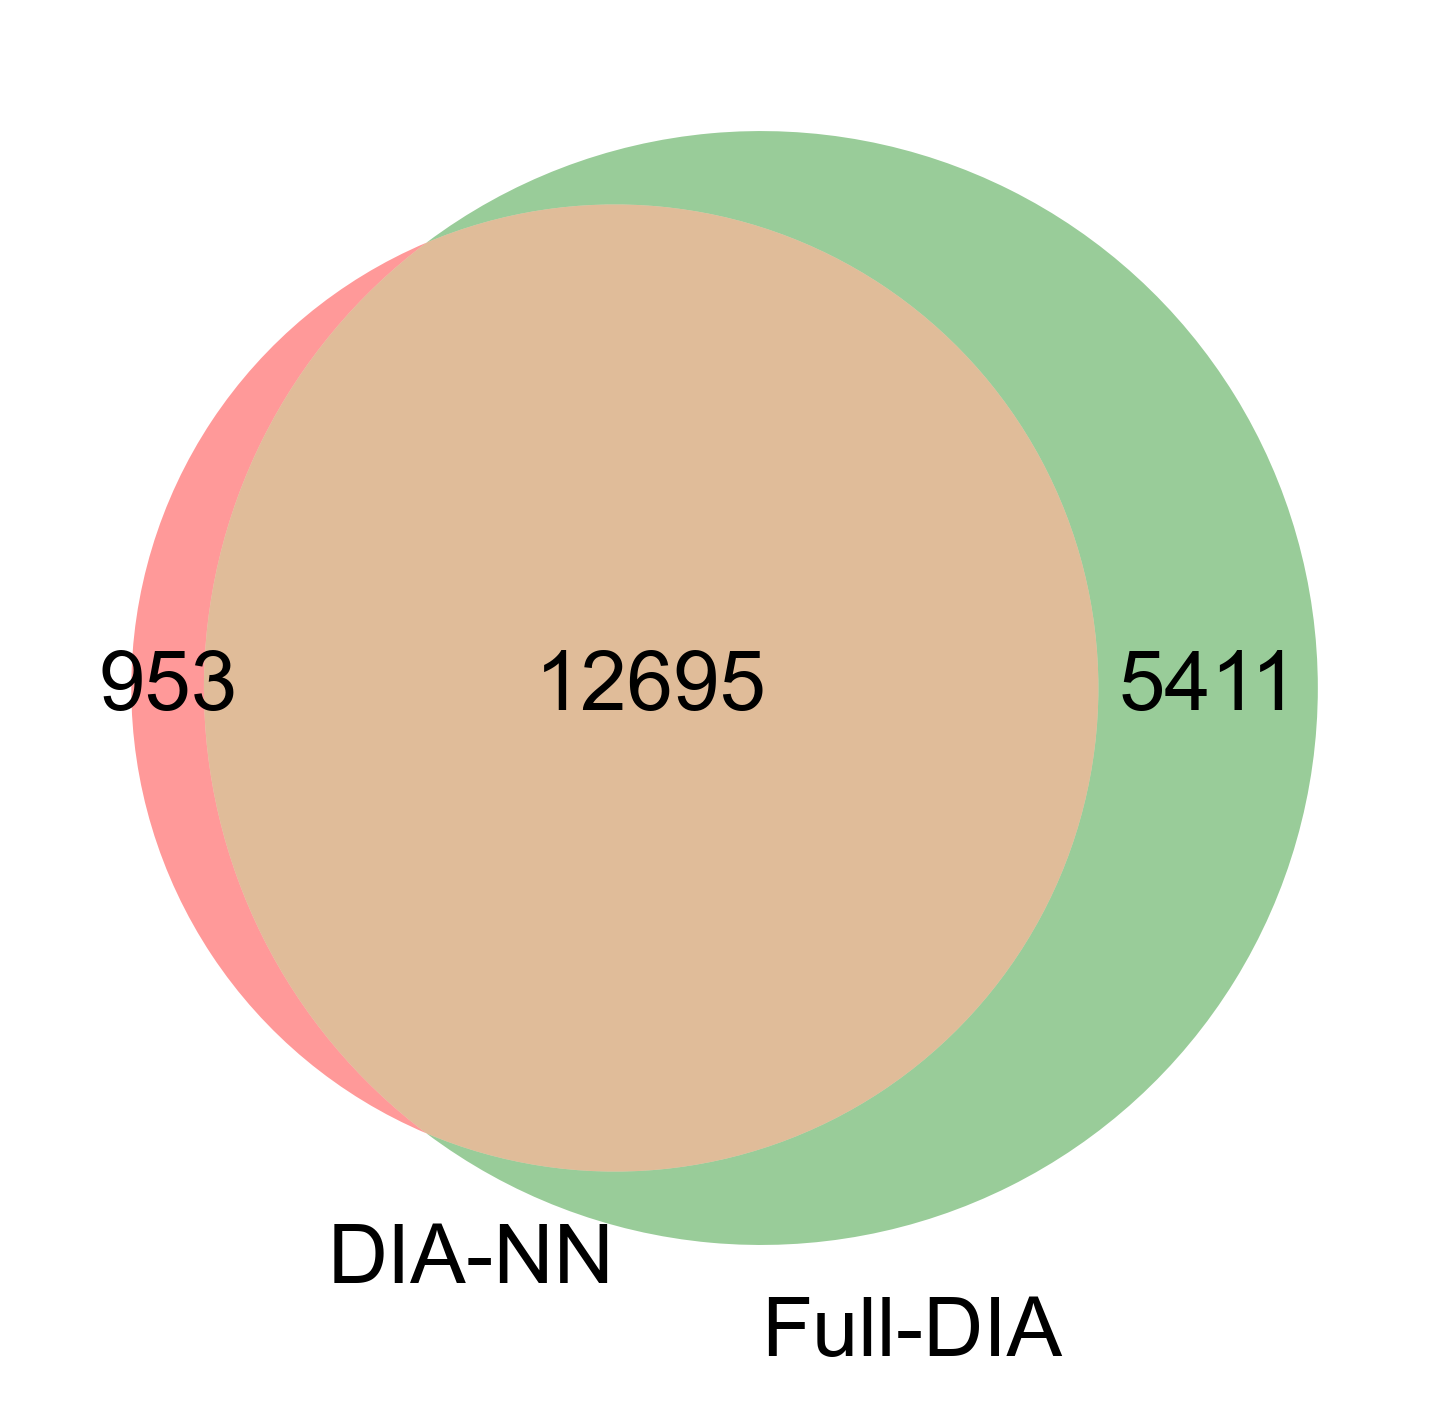

In [4]:
from matplotlib_venn import venn2
v = venn2([prs1, prs2], ['DIA-NN', 'Full-DIA'])
for t in v.set_labels + v.subset_labels:
    if t: t.set_fontsize(20)
plt.tight_layout()
plt.show()

#### venn for pg

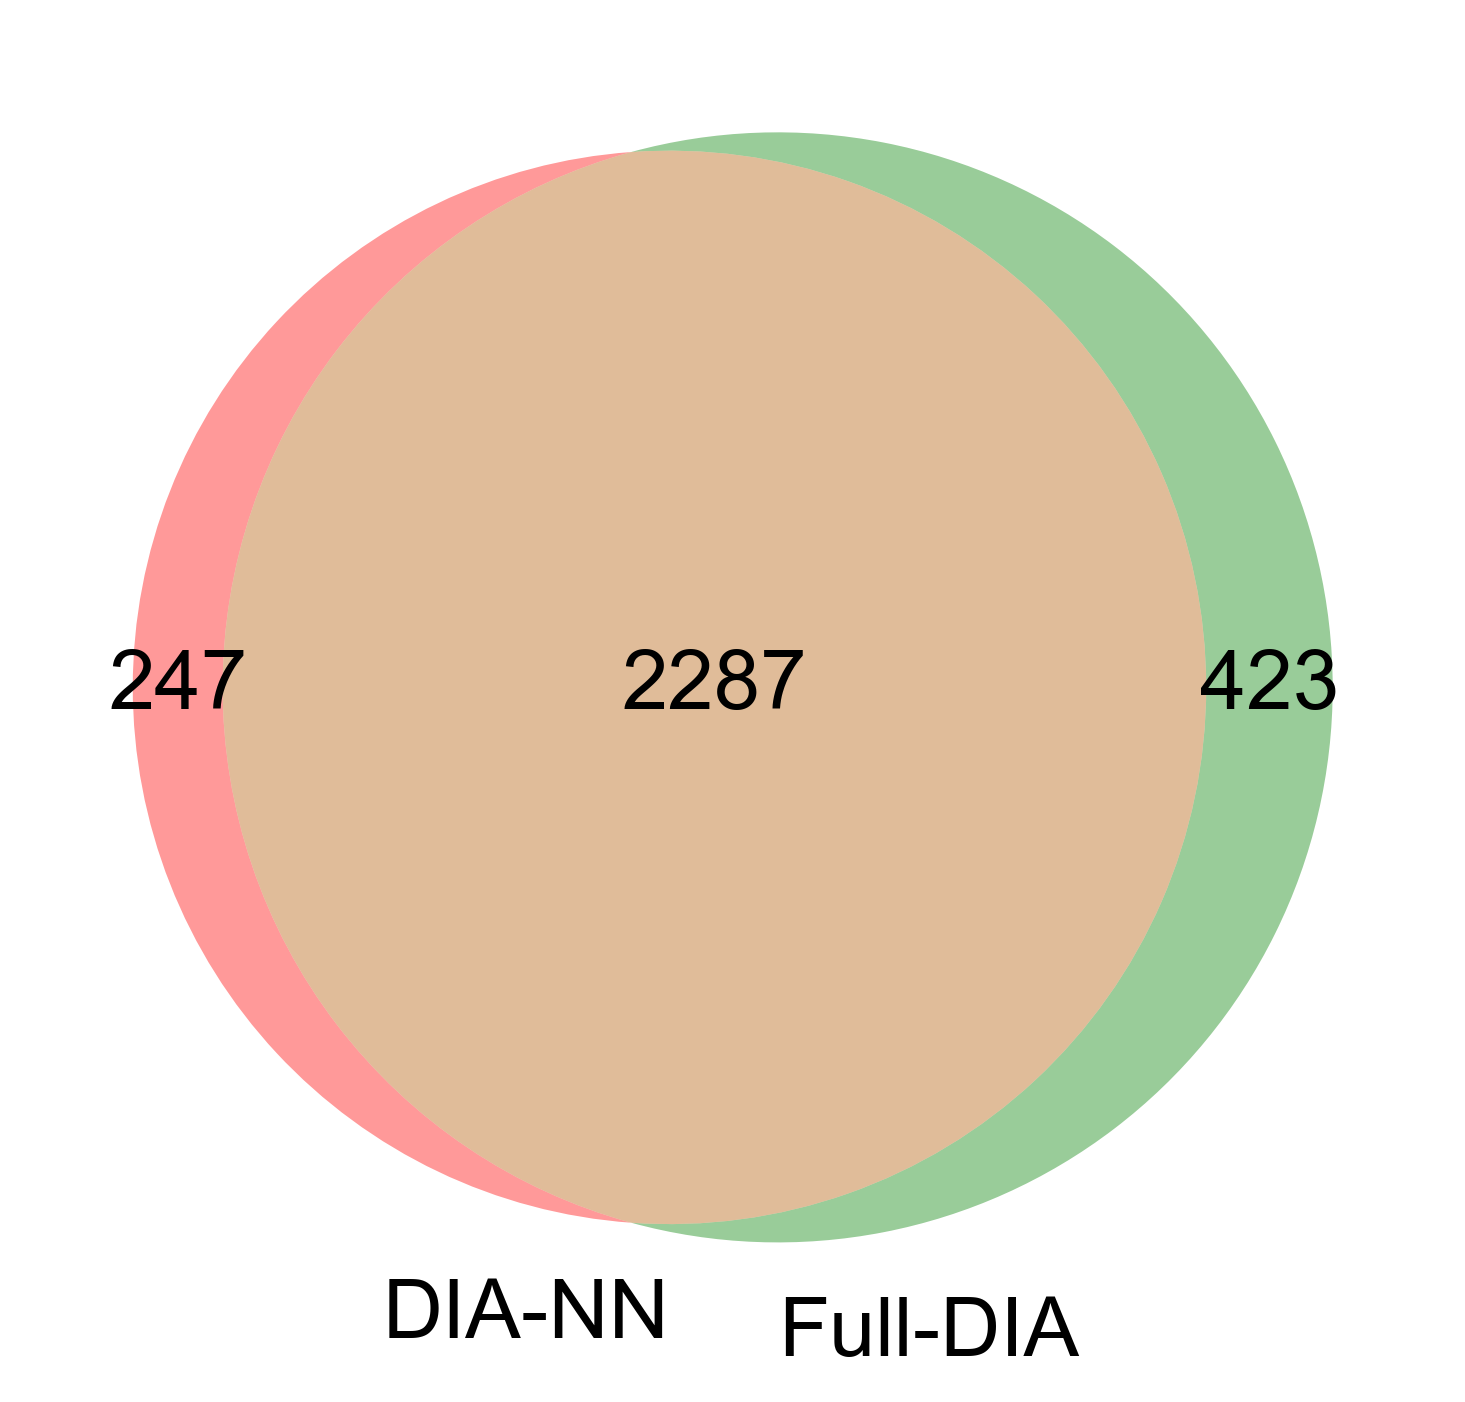

In [5]:
v = venn2([pgs1, pgs2], ['DIA-NN', 'Full-DIA'])
for t in v.set_labels + v.subset_labels:
    if t: t.set_fontsize(20)
plt.tight_layout()
plt.show()

#### append species

In [6]:
df_raw1['species'] = df_raw1['Protein.Names'].apply(
        lambda row: ';'.join(set([part.split('_')[1] for part in row.split(';')]))
    )
df_raw1 = df_raw1[df_raw1['species'].str.count(';') == 0]
df_raw2['species'] = df_raw2['Protein.Names'].apply(
        lambda row: ';'.join(set([part.split('_')[1] for part in row.split(';')]))
    )
df_raw2 = df_raw2[df_raw2['species'].str.count(';') == 0]

#### calculating the external FDR

In [7]:
df_plot = pd.DataFrame()
df_plot['Method'] = np.repeat(['diann', 'fulldia'], 4)
df_plot['Level'] = ['pr', 'pr', 'pg', 'pg'] * 2
df_plot['Metric'] = ['TP', 'FP'] * 4
count_v = []
for i, row in df_plot.iterrows():
    method, level, metric = row['Method'], row['Level'], row['Metric']
    if (method == 'diann') and (level == 'pr'):
        df = df_raw1[df_raw1['Global.Q.Value'] < 0.01].copy()
        df['id'] = df['Precursor.Id']
    if (method == 'diann') and (level == 'pg'):
        df = df_raw1[df_raw1['Global.PG.Q.Value'] < 0.01].copy()
        df['id'] = df['Protein.Group']
    if (method == 'fulldia') and (level == 'pr'):
        df = df_raw2[df_raw2['Global.Q.Value'] < 0.01].copy()
        df['id'] = df['Precursor.Id']
    if (method == 'fulldia') and (level == 'pg'):
        df = df_raw2[df_raw2['Global.PG.Q.Value'] < 0.01].copy()
        df['id'] = df['Protein.Group']
    df = df[['id', 'species']].drop_duplicates()
    if metric == 'TP':
        count_v.append(sum(df['species'] == 'HUMAN'))
    else:
        count_v.append(sum(df['species'] == 'ARATH'))
df_plot['Count'] = count_v
df_plot["Level_Metric"] = df_plot["Level"] + "_" + df_plot["Metric"]
tp_values = df_plot[df_plot['Metric'] == 'TP'].set_index(['Method', 'Level'])['Count']
df_plot['Display_Value'] = df_plot.apply(
    lambda row: (
        f'{row.Count}\n({row.Count/tp_values.loc[(row.Method, row.Level)]*100:.1f}%)' if row.Metric == 'FP' else f'{row.Count}'
    ),
    axis=1
)
df_plot.copy()

,Method,Level,Metric,Count,Level_Metric,Display_Value
0,diann,pr,TP,13550,pr_TP,13550
1,diann,pr,FP,91,pr_FP,91\n(0.7%)
2,diann,pg,TP,2490,pg_TP,2490
3,diann,pg,FP,38,pg_FP,38\n(1.5%)
4,fulldia,pr,TP,17915,pr_TP,17915
5,fulldia,pr,FP,178,pr_FP,178\n(1.0%)
6,fulldia,pg,TP,2662,pg_TP,2662
7,fulldia,pg,FP,44,pg_FP,44\n(1.7%)


#### plot TP/FP

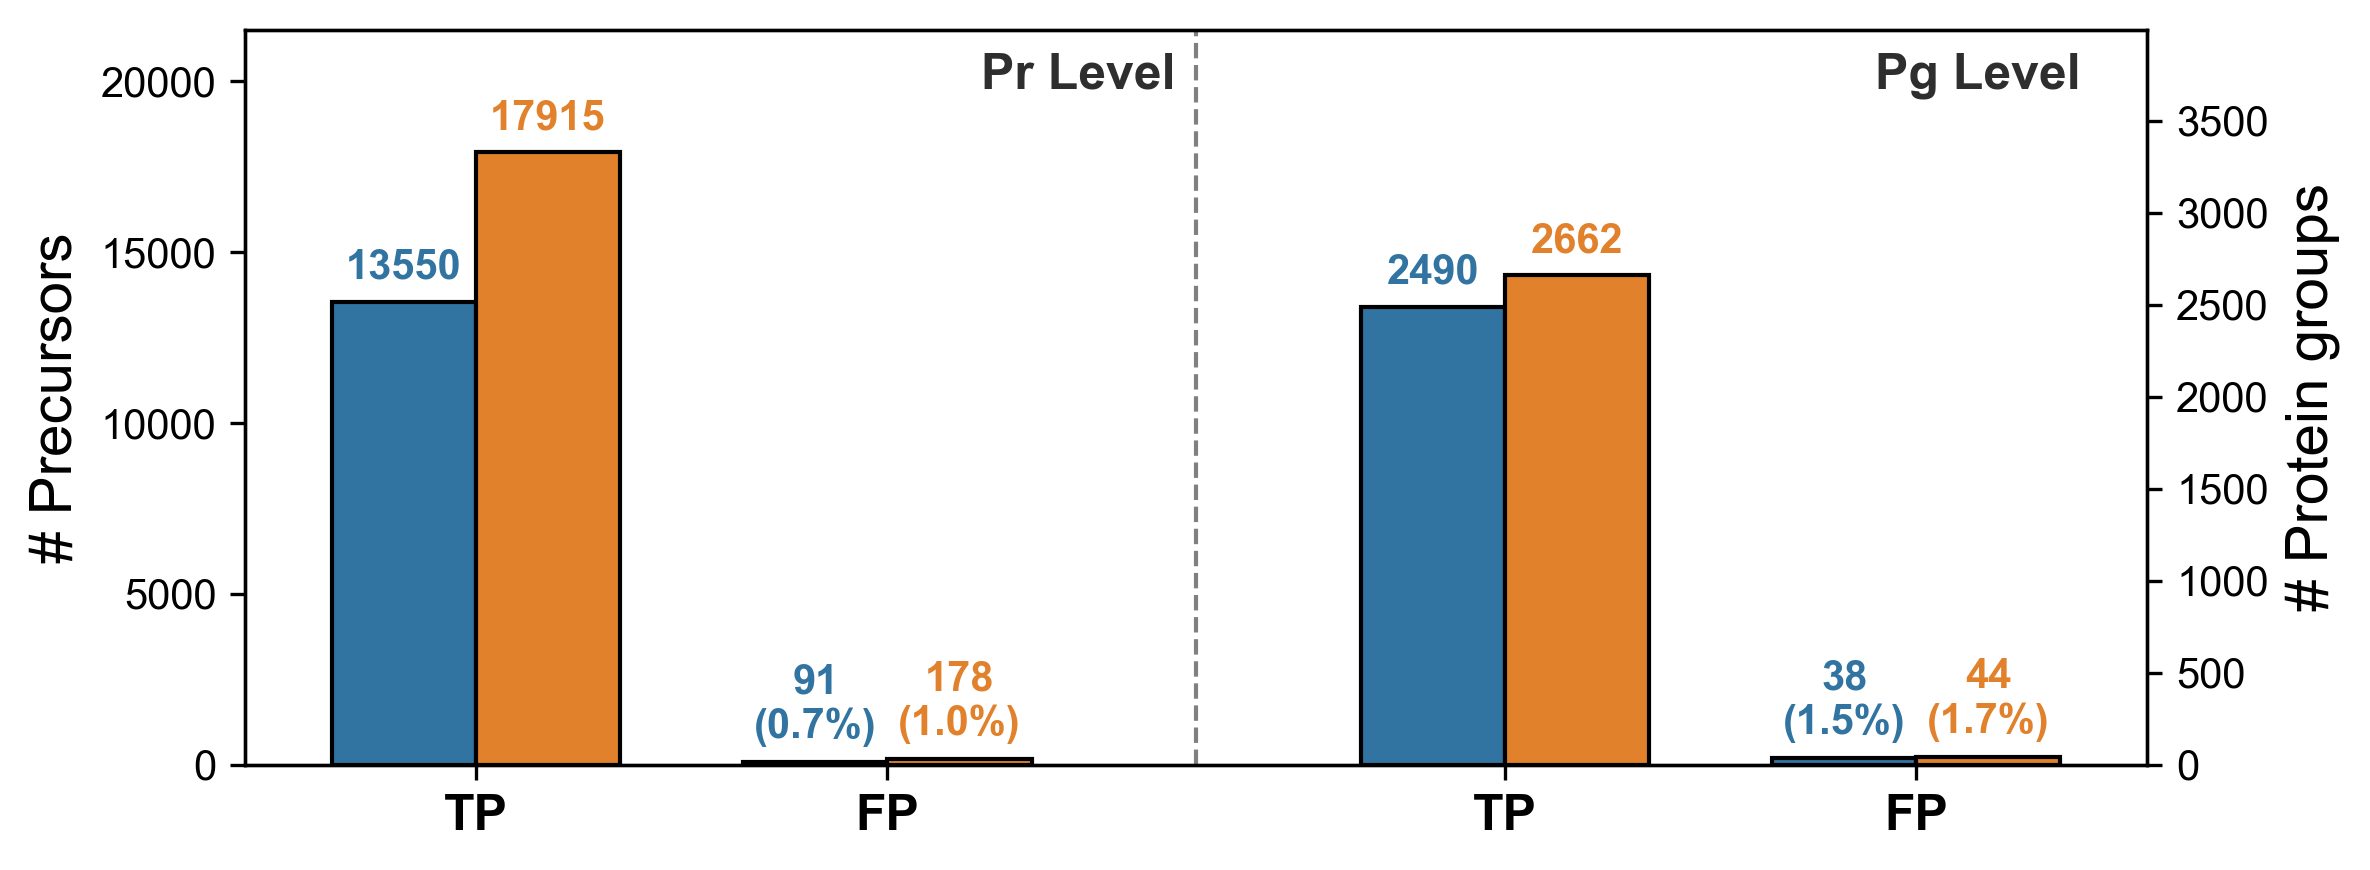

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
method_colors = {'diann': '#3274a1', 'fulldia': '#e1812c'}

ax1 = ax
ax2 = ax1.twinx()

peptide_max = df_plot[df_plot["Level"] == "pr"]["Count"].max()
protein_max = df_plot[df_plot["Level"] == "pg"]["Count"].max()
ax1.set_ylim(0, peptide_max * 1.2)
ax2.set_ylim(0, protein_max * 1.5)
ax1.set_ylabel('# Precursors', fontsize=14)
ax2.set_ylabel('# Protein groups', fontsize=14)

x_groups = {"pr_TP": 0, "pr_FP": 1, "pg_TP": 2.5, "pg_FP": 3.5}
width = 0.35

for (method, level_metric), grp in df_plot.groupby(
        ["Method", "Level_Metric"]
):
    level, metric = level_metric.split("_")
    ax = ax1 if level == "pr" else ax2

    # pos
    base_x = x_groups[f"{level}_{metric}"]
    offset = -width / 2 if method == "diann" else width / 2
    x = base_x + offset

    # bar
    bar = ax.bar(
        x, grp["Count"].values[0],
        width=width,
        color=method_colors[method],
        edgecolor="k",
    )

    # text values
    label_y = grp["Count"].values[0] + (0.02 * ax.get_ylim()[1])
    ax.text(
        x, label_y, f"{grp['Display_Value'].values[0]}",
        ha="center", va="bottom",
        color=method_colors[method],
        fontsize=10,
        weight='bold'
    )

ax1.set_xticks(list(x_groups.values()))
ax1.set_xticklabels(["TP", "FP", "TP", "FP"],
                    fontsize=12,
                    weight='bold')
ax1.axvline(1.75, color="gray", ls="--", lw=1)
ax1.text(1.7, ax1.get_ylim()[1] * 0.97, "Pr Level",
         ha="right", va="top",
         fontsize=12, weight='bold', color='#2e2e2e')
ax1.text(3.4, ax1.get_ylim()[1] * 0.97, "Pg Level",
         ha="left", va="top",
         fontsize=12, weight='bold', color='#2e2e2e')
plt.tight_layout()
plt.show()